In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

In [ ]:
class Maze:

    def __init__(self, start: tuple, finish: tuple, n: int, pitfalls: np.array, epsilon = 0.1, gamma = 0.9, alpha = 0.1):
        '''
        Args:
        - start, finish tuples of size 2
        - n integer
        - pitfalls: np.array() of size (2, n_pitfalls)
        '''
        
        # set characteristics of maze
        self.epsilon, self.gamma, self.alpha = epsilon, gamma, alpha
        self.start = start
        self.dim = n
        self.finish = finish
        self.pitfalls = pitfalls

        # define an attribute to store the total times the maze was solve
        self.times_solved = 0

        # set the actions on the agent as right, left, down, up
        self.actions = {0: (0, 1), 1: (0, -1), 2: (1, 0), 3: (-1, 0)}
        
        # initialize maze as an np.array of size (n+2, n+2) with walls valued -2, pitfalls -1, empty positions 0, exit 2; 
        # in visualizing we will also set current position of agent at maze as 1 
        self.initialize_maze()
        
        # initialize the Q-values; those will be updated
        self.qvalues = np.zeros((n+2, n+2, 4))

        # set current position of the agent; those will charge
        self.x, self.y = start

    def play_one_game(self, visualize = False):
        
        if visualize:
            self.visualize_maze(self.x, self.y)

        while True:
            
            # pick an action to perform on current state
            action = self.greedy_action()
            dx, dy = self.actions[action]

            # new possible position
            x_new, y_new = self.x + dx, self.y + dy

            # update the q-value Q(s, action)
            self.qvalues[self.x, self.y, action] += self.alpha*( self.reward(x_new, y_new) + self.gamma*np.max(self.qvalues[x_new, y_new, :]) - self.qvalues[self.x, self.y, action] )

            # visualize the maze on the new possible position
            if visualize:
                self.visualize_maze(x_new, y_new)

            # check if the game is on
            value = self.maze[x_new, y_new]
            if value < 0 : 
                if visualize:
                    print(f'end up on a wall; game resets')
                # reset state to initial
                self.x, self.y = self.start
                break
            elif value == 2:
                if visualize:
                    print(f'Congrats! You found the exit.')
                # increase the times the mazed was solved
                self.times_solved +=1

                # reset state to initial
                self.x, self.y = self.start
                break

            # game goes on; update current state and continue
            self.x, self.y = x_new, y_new
    
    def reward(self, a, b):
        '''return the reward at position a,b as follows:
        walls -> -50, empty -> 0, exit -> +200
        could also penaltize each step as -1, so to find exit in fastest way
        '''

        maze_value = self.maze[a, b]
        if maze_value == 0:
            return 0
        elif maze_value < 0 :
            return -50
        elif maze_value == 2:
            return +200


    def initialize_maze(self):
        
        self.maze = np.zeros((self.dim+2, self.dim+2))

        # set outer the walls
        self.maze[[0, -1]] = -2
        self.maze[:, [0, -1]] = -2

        # set inner pitfalls
        self.maze[self.pitfalls[:, 0], self.pitfalls[:, 1]] = -1
        
        # set the exit
        self.maze[self.finish[0], self.finish[1]] = 2
    
    def greedy_action(self):
        ''' pick an action to act on the current state and to update value Q(s, a)
        '''
        
        # pick at random a number btwn 0-1
        prob = np.random.random()
        
        # pick with probability 1-epsilon the action that maximize the 4 q-values of current state
        max_action = np.argmax(self.qvalues[self.x, self.y, :])
        
        if prob>= self.epsilon:
            # return one of the actions with max Q-value, i.e. in case of a tie choose one at random
            return np.random.choice( np.argwhere( self.qvalues[self.x, self.y, :] == np.max(self.qvalues[self.x, self.y, :]) ).reshape(-1) )
        
        else:
            # remove the max action
            actions_num = [0, 1, 2, 3]
            actions_num.remove(max_action)
            # pick at rendom one of the other actions
            return np.random.choice(actions_num) 

    def visualize_maze(self, a, b):
        '''a, b is the next position if possible
        '''

        # store the value of the maze at the agent's current position
        maze_value_at_current_position = self.maze[a, b]

        # set the value of the maze at that position depending on whether it is empty or a wall
        self.maze[a, b] = 1 if maze_value_at_current_position == 0 else 1.5
        
        # visulize the maze
        plt.imshow(self.maze)
        display(plt.gcf())
        clear_output(wait=True)  # Clear the output for the next iteration
        plt.close('all')  # Close the current figure to free memory
        time.sleep(0.3)
        plt.close()

        # reset maze value
        self.maze[a, b] = maze_value_at_current_position
    
    def optimum_path(self, visualize = True):
        '''deterministic path after trained: pick action that maximize current state; do not update q-values
        '''

        # now alwayes pick best action and move
        # store the optimum path as a list of (x, y, action)
        optimum_path = []

        while True:
            # pick the best action and apply it to current position
            action = np.argmax(self.qvalues[self.x, self.y, :])
            dx, dy = self.actions[action]

            # store current position and best action on it
            optimum_path.append((self.x, self.y, action))

            x_new, y_new = self.x + dx, self.y + dy
            
            if visualize:
                self.visualize_maze(x_new, y_new)
            
            # check if the game is on
            value = self.maze[x_new, y_new]
            if value < 0 :
                print(f'end up on a wall; game resets')
                # reset state to initial
                self.x, self.y = self.start
                break
            elif value == 2:
                print(f'Congrats! You found the exit.')
                # reset state to initial
                self.x, self.y = self.start
                break

            self.x, self.y = x_new, y_new

        # reset position
        self.x, self.y = self.start
        
        return optimum_path

    def visualize_optimum_path(self):

        path = self.optimum_path()
        
        # set starting position
        self.maze[self.start[0], self.start[1]] = 1

        # set maze values for the optimum path
        for (x, y, a) in path[1:]:
            self.maze[x, y] = 1.5

        plt.imshow(self.maze)
        plt.show()

        # reset starting position
        self.maze[self.start[0], self.start[1]] = 0
        
        # reset maze values for the optimum path
        for (x, y, a) in path:
            self.maze[x, y] = 0


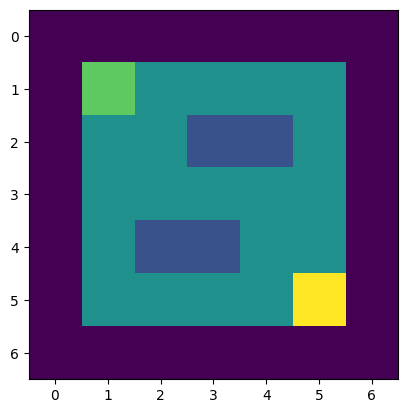

In [25]:
n_dim = 5
pitfalls = np.array([[2,3], [2,4], [4, 2], [4, 3] ])
game = Maze(start=(1, 1), finish=(5, 5), n = n_dim, pitfalls = pitfalls )
game.visualize_maze(a = 1, b = 1)

In [26]:
# train the agent 
n_epochs = 500
q_values_store_per_game = np.zeros((n_epochs, n_dim+2, n_dim+2, 4))
for episode in range(n_epochs):
    game.play_one_game(visualize=False)
    q_values_store_per_game[episode, :, :, :] = game.qvalues.copy()

Congrats! You found the exit.


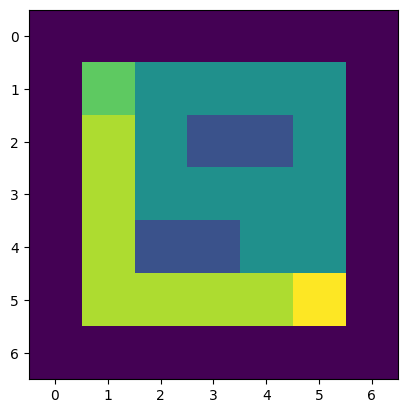

In [27]:
# visualize the best solution
game.visualize_optimum_path()

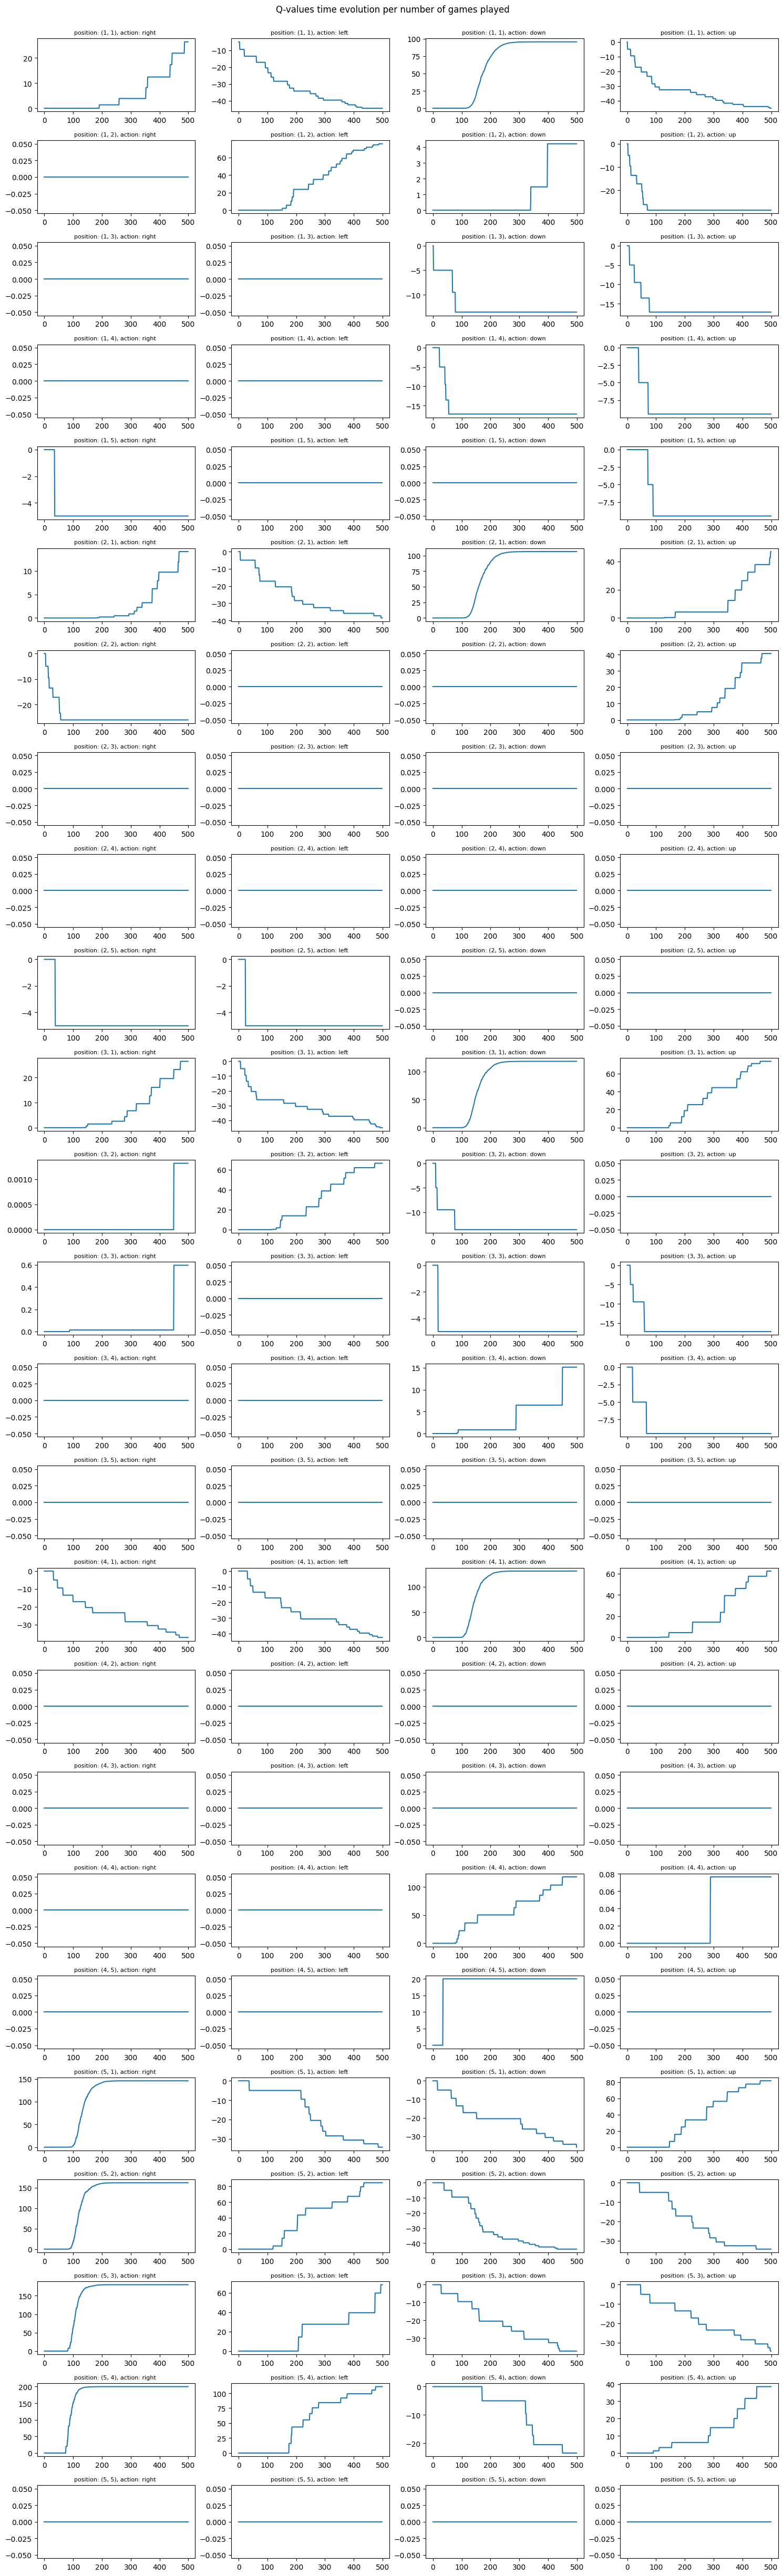

In [ ]:
# Plot the time evolution of the Q-values

fig, axes = plt.subplots(25, 4, figsize=(15, 50))
actions_to_directions = {0:'right', 1:'left', 2:'down', 3:'up'}

for i in range(5):
    for j in range(5):
        for action in range(4):
            ax = axes[5*i+j, action]
            ax.plot(q_values_store_per_game[:, i+1, j+1, action]) 
            ax.set_title(f"position: {(i+1, j+1)}, action: {actions_to_directions[action]} ", fontsize=8)

fig.suptitle('Q-values time evolution per number of games played')
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

Congrats! You found the exit.


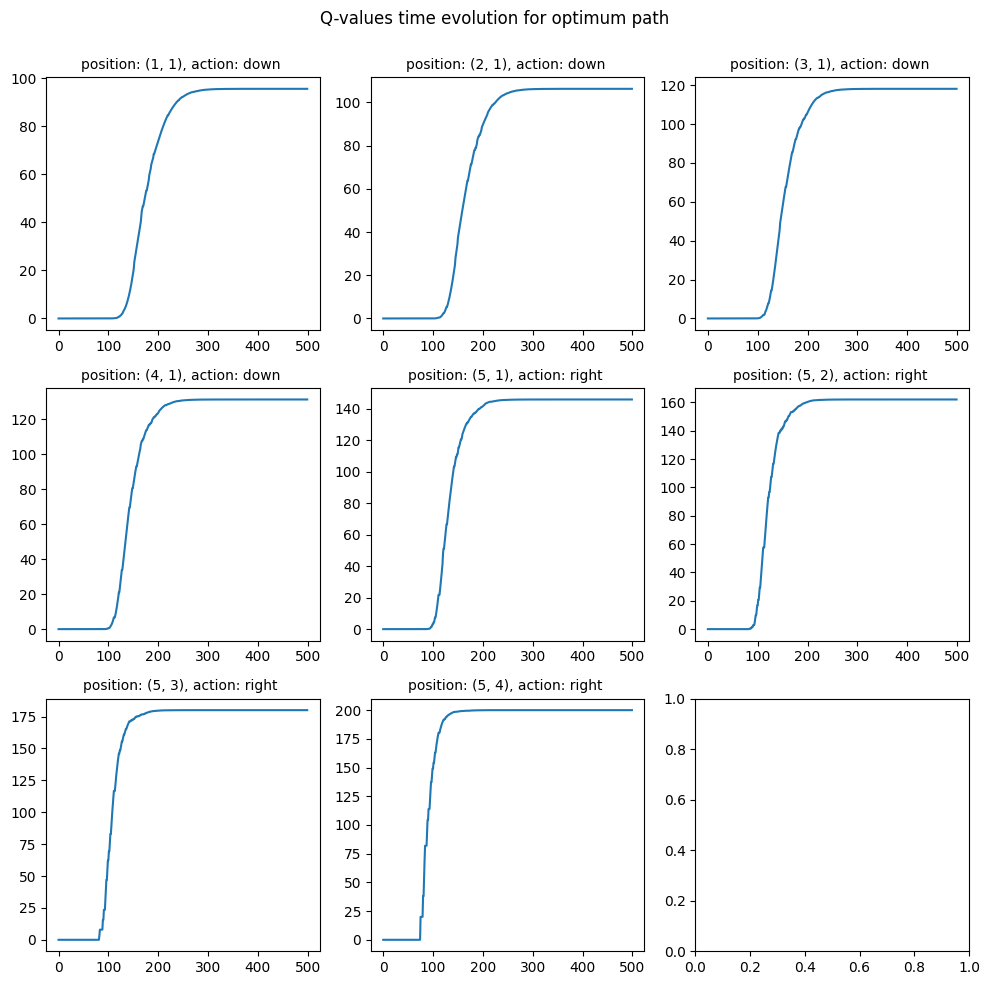

In [39]:
# visualize Q-values evolution only for the optimal path 
path = game.optimum_path(visualize=False)

fig, axes = plt.subplots((len(path)+1)//3, 3, figsize=(10, 10))
actions_to_directions = {0:'right', 1:'left', 2:'down', 3:'up'}

for i, (x, y, a) in enumerate(path):
    ax = axes[i//3, i%3]
    ax.plot(q_values_store_per_game[:, x, y, a]) 
    ax.set_title(f"position: {(x, y)}, action: {actions_to_directions[a]} ", fontsize=10)

fig.suptitle('Q-values time evolution for optimum path')
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

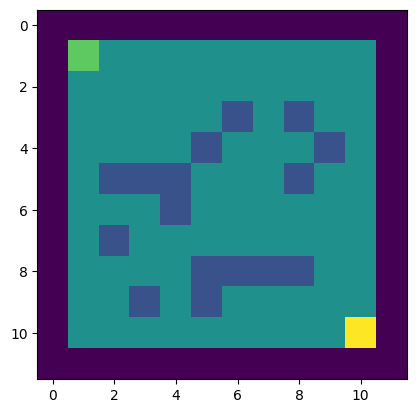

In [45]:
n_dim = 10
pitfalls = np.random.randint(2, 10, size=(20, 2))
game2 = Maze(start=(1, 1), finish=(n_dim, n_dim), n = n_dim, pitfalls = pitfalls )
game2.visualize_maze(a = 1, b = 1)

In [ ]:
n_epochs = 10000
for _ in range(n_epochs):
    game2.play_one_game(visualize=False)

end up on a wall; game resets


Congrats! You found the exit.


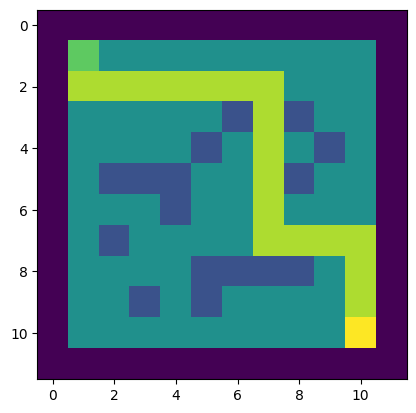

In [48]:
game2.visualize_optimum_path()